In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from mmctools.plotting import plot_timeheight
from mmctools.plotting import plot_timehistory_at_height
from mmctools.plotting import plot_profile
from mmctools.plotting import plot_spectrum

In [4]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16

# Demonstrate standard plotting tools

## Time history plots

In [5]:
TTUdata = '/projects/mmc/SWIFTRegion/8Nov2013/TTU_20131108_10min.csv'

In [6]:
df = pd.read_csv(TTUdata,parse_dates=True,index_col='datetime')

In [7]:
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
df['wdir'] = 180. + np.arctan2(df['u'],df['v'])*180./np.pi

In [8]:
df.head()

,height,u,v,w,thetav,uu,vv,ww,uv,uw,vw,tw,wspd,wdir
datetime,,,,,,,,,,,,,,
2013-11-08,0.9,-0.252493,2.871292,-0.051643,292.658722,0.106279,0.180421,0.066140,-0.014938,0.000003,-0.031162,-0.010918,2.882372,174.974496
2013-11-08,2.4,-0.248722,3.382154,-0.206384,292.816727,0.118248,0.185434,0.091704,-0.017369,-0.006292,-0.051677,0.021208,3.391287,175.794068
2013-11-08,4.0,-0.226337,3.390344,-0.109889,293.121340,0.117431,0.212125,0.147491,0.036626,0.047150,-0.010662,0.086992,3.397891,176.180648
2013-11-08,10.1,-0.547638,4.537476,-0.014839,293.469409,0.109090,0.252866,0.120394,0.020934,0.012241,-0.041621,0.001540,4.570404,173.118128
2013-11-08,16.8,-0.232308,5.424099,-0.036734,293.747246,0.098872,0.261779,0.099571,0.028755,0.009168,-0.040850,0.004686,5.429072,177.547585


/home/dallaert/.conda-envs/py3env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


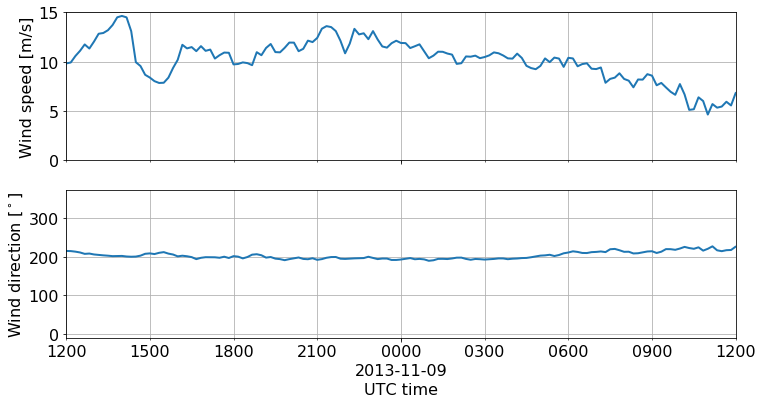

In [9]:
fig,ax = plot_timehistory_at_height(df,
                    fields = ['wspd','wdir'],
                    heights = 80,
                    timelimits = ['2013-11-08 12:00:00','2013-11-09 12:00:00'],
                    fieldlimits = {'wspd':(0,15)},
                    )

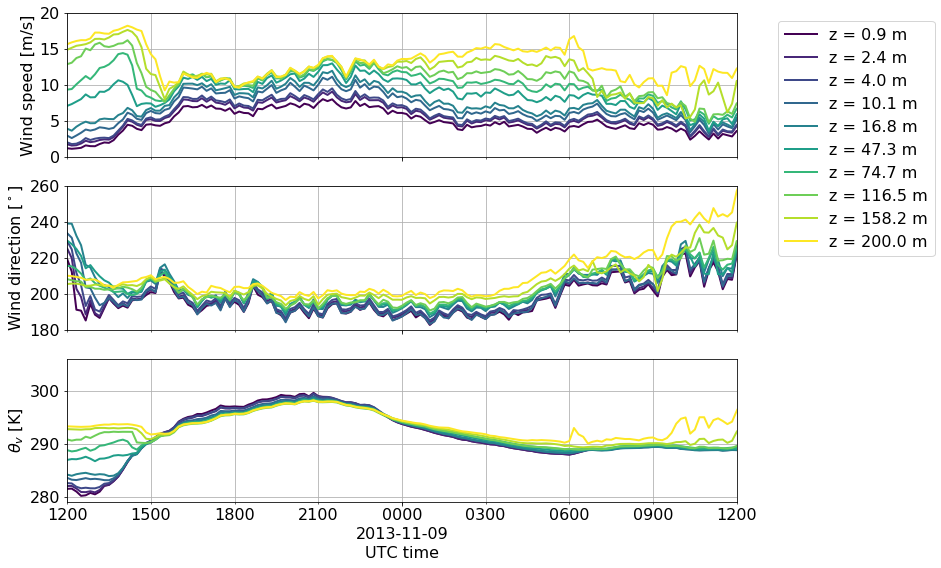

In [10]:
fig,ax = plot_timehistory_at_height(df,
                    fields = ['wspd','wdir','thetav'],
                    heights = df.height.unique(),
                    timelimits = ['2013-11-08 12:00:00','2013-11-09 12:00:00'],
                    fieldlimits = {'wspd':(0,20),'wdir':(180,260)},
                    colormap = 'viridis'
                    )

## Time-height contour and profile plots

In [11]:
TTUdata = '/projects/mmc/SWIFTRegion/8Nov2013/NNinterp_TTU_data_20131108.csv'
df = pd.read_csv(TTUdata,parse_dates=True,index_col='datetime')
df.columns = ['height','wspd','wdir']

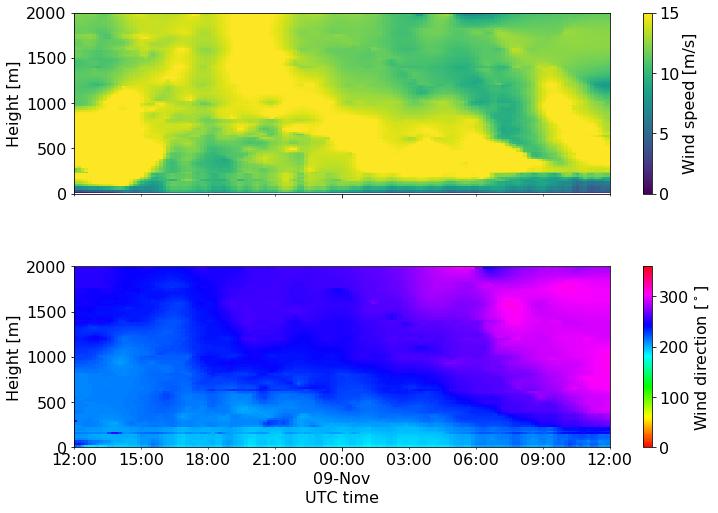

In [12]:
fig,ax = plot_timeheight(df,
                    fields = ['wspd','wdir'],
                    colorscheme = {'wdir': 'hsv'},
                    heightlimits = (0,2000),
                    fieldlimits = {'wspd':(0,15),'wdir':(0,360)},
                    )

In [13]:
# Calculate hourly averages
df_1h = df.pivot(columns='height',values=['wspd','wdir']).resample('1h').mean().stack()
df_1h.reset_index(inplace=True)
df_1h.set_index(['datetime'],inplace=True)

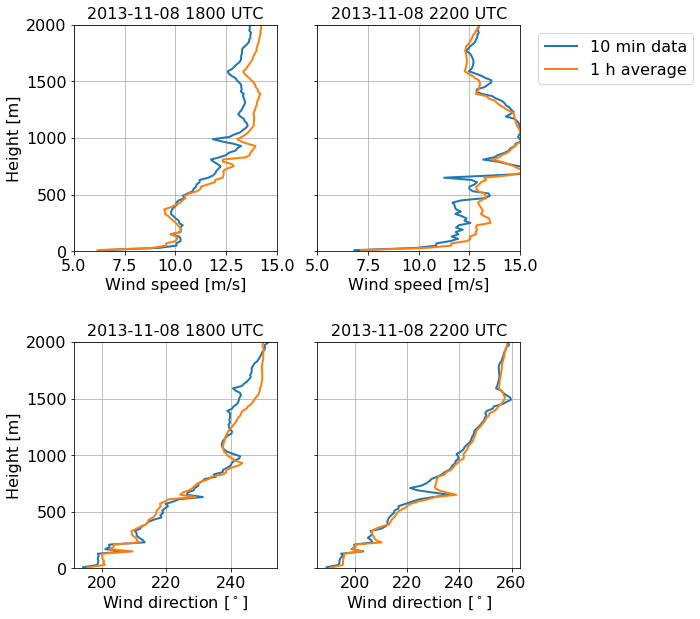

In [14]:
fig,ax = plot_profile({'10 min data':df, '1 h average':df_1h},
                    fields = ['wspd','wdir'],
                    times = ['2013-11-08 18:00:00','2013-11-08 22:00:00'],
                    heightlimits = [0,2000],
                    fieldlimits = {'wspd':(5,15)},
                    stack_by='datasets'
                   )

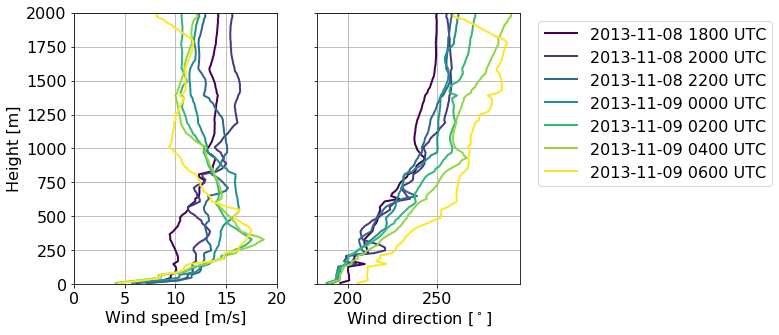

In [15]:
fig,ax = plot_profile(df_1h,
                    fields = ['wspd','wdir'],
                    times = ['2013-11-08 '+str(int(i))+':00:00' for i in range(18,24,2)] + \
                              ['2013-11-09 '+str(int(i))+':00:00' for i in range(0,7,2)],
                    heightlimits = [0,2000],
                    fieldlimits = {'wspd':(0,20)},
                    colormap='viridis'
                   )
#fig.savefig('profile_evolution.png',bbox_inches='tight')

## Spectra plot

Use 50Hz tower data to compute spectra

In [16]:
TTUdata = '/projects/mmc/SWIFTRegion/8Nov2013/TTU_20131108_50Hz.csv'

In [17]:
df = pd.read_csv(TTUdata,parse_dates=True,index_col='datetime')

In [18]:
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
df['wdir'] = 180. + np.arctan2(df['u'],df['v'])*180./np.pi

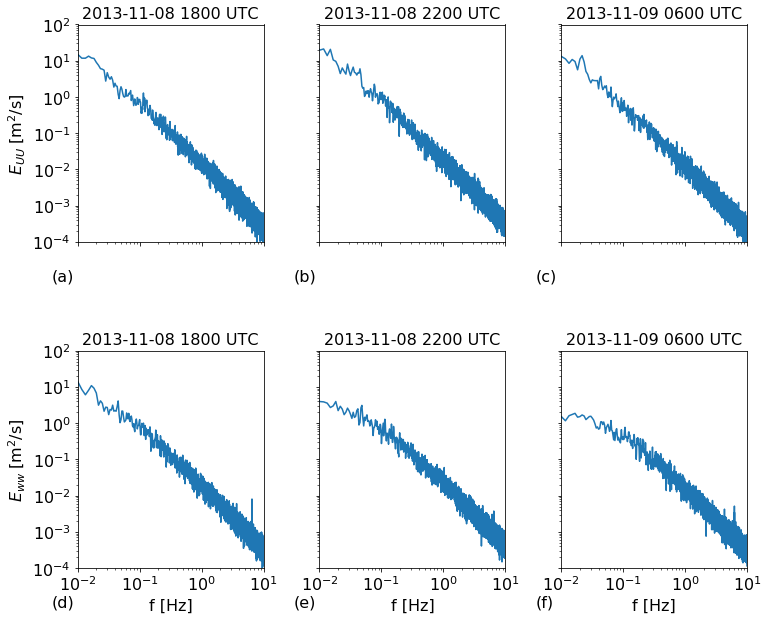

In [19]:
fig,ax = plot_spectrum(df,
                     fields = ['wspd','w'],
                     times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                     height = 80,
                     freqlimits = (0.01,10),
                     fieldlimits = {'w':(1.0e-4,1.0e2)}
                   )